# Image search with autoencoders

Autoencoders are an architecture that have a variety of applications from [denoising data](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf) to [generative models](http://kvfrans.com/variational-autoencoders-explained/).

In this post we will look at how to search for similar images given a query image with autoencoders and implement one with [keras](http://keras.io). While we will focus on image searches autoencoders have been shown to work well in other settings as well, for example text-based problems such as retrieving for relevant news articles (see the resource section at the end of this post).

# Autoencoders

## The gist

Autoencoders are simply neural networks that learn the mapping $f:X\mapsto X$. Does that sound too easy? Are you wondering why we would want to predict the input we are already given?

The key idea that makes this mapping useful is that a "bottleneck" is placed in the middle of the network which implicitly forces the network to learn a compressed representation of the input data. It is important to note that this is the only output from the network that we are actually interested in.

More specifically we think of an autoencoder as two pieces. First there is the _encoder_, the first half of the network that maps $X\in \mathbb{R}^{n}$ to some vector in $\mathbb{R}^{d}$ where $d<n$. Second we have the _decoder_ which maps that vector back to the orignal feature space $\mathbb{R}^{n}$. The vector output by the encoder is known as the _latent representation_ of the data and is what we will use to search for images by. Again, it is important to understand that at the end of the day all we really care about is the output of the bottleneck.

In keras implementing an autoencoder is (almost) as simple as

```python
import keras
model = keras.models.Sequential([
    Dense(1000),
    Dense(500),
    Dense(250),
    Dense(64),
    Dense(250),
    Dense(500),
    Dense(1000)
])
```

Note that the output of the middle layer `Dense(64)` is the latent representation, or code.

## The intuition

One nice thing about autoencoders is that the idea described above is very intuitive. Suppose our data $X$ lives in $\mathbb{R}^{n}$ and one of the hidden layers of $f$ outputs a vector of dimmension $d<n$. Then, it follows that if $f$ reconstructs $X$ well after reducing the input in dimmensionality then that $d$-dimmensional vector must contain a lot of information about the input itself in order to reproduce it.

# Autoencoders for searching

So how do autoencoders apply to searching?

Let's consider the use case where we have a set of images $X$, and for a given image, $q$, we would like to retrieve all images in $X$ that are "similar" to $q$.

One such way to do this with an autoencoder is to keep a list of key-value pairs of each image $x\in X$ and its encoded representation $\hat{x}$ (the output of the latent layer when we predict on $x$). Recall these codes are simply vectors, so we can compute similarity scores of $\hat{q}$ with each $\hat{x}$, returning the images which scored highest.

Now, this method is already more efficient than simply computing the similarity scores over the raw values in $X$ - in the sense that the encoded representations are much smaller in dimmension. Nevertheless, both approaches run in linear time, that is the more images we have in our database, the longer the search will take and the less benefit we see in performance from computing the similarity scores on smaller vectors.

It turns out we can still use the codes to perform a faster search in constant time, we just need to build the autoencoder with one slight modification. Instead of mapping the input to vectors of dimmension $d$, we define the encoder as $\phi:\mathbb{R}^{n}\mapsto\{0,1\}^{d}$ ($d$-bit binary codes). To perform the search over these KVPs we implement a data scructure called a ["semantic hashing table"](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf). Don't let the name intimidate you, the data scructure is essentially a hash map where the keys are $d$-bit integers (converted from the output of $\phi$) and the values are lists (at least that's the simple python implementation) and is initialized with the following algorithm.

```python
A  = collections.defaultdict(list)
for image in images:
    code = phi(image)
    A[code].append(image)
```

Now, for our query image $q$, we can return all images $x\in X$ such that the hamming distince (number of bits that differ) of $\phi(q)$ and $\phi(x)$ is less than some predetermined threshold $t$. The following python snippet shows how this is done in constant time.

```python
results = list()
q_hat = phi(q)
for key, images in A.items():  # A has no more than 2^d keys
    if hamming_distance(q_hat, key) < t:
       results.extend(images)
```

In this section we've oversimplified the implementation just a bit. To get a full idea of how to implement this search see below.

# A few remarks on building and training the autoencoder

## Learning binary codes

You may be asking how does one constrain the neural network to learn binary codes. It turns out this is actually rather simple. Several techniques are discussed in [semantic hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf), however the simplest method, described [here](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf), is to round the outputs of the encoder up to 1 or down to 0 (these will already be values between 0 and 1 since we use a softmax for the activation of this layer) and then compute the gradient update as if the rounding never occurred.

We can do this in keras with a custom layer using `keras.backend.round()` and `keras.backend.stop_gradient()` as follows

```python
import keras
from keras.layers import Lambda
def binarize(x):
    return x + K.stop_gradient(K.round(x) - x)
Binarize = Lambda(binarize, output_shape=lambda x: x, name='encoding')
```

## Choosing the latent dimmension and threshold

When choosing the size of the latent dimmension it is useful to consider the following heuristic. As a specific example we'll consider searching over the MNIST digits since that's the data we'll work with below. Specifically we will use the MNIST training set provided by `keras.datasets.mnist` which contains 60,000 images.

In the papers referenced at the end of this post the author's found good results when each code mapped to approximately 0.4 items (images in our case). Following this pattern, we will chose $d$ such that $60000/2^{d}\approx 0.4$, that is $d=17$. The key idea is for $d$ to be large enough for the model to train well, yet small enough that we will actually find images with codes within a given hamming distance of our query code.

Choosing the threshold $t$ will depend on the use case. Just keep in mind that the number of images, $n$, you should expect to retrieve for a given query is

$$n\approx\frac{|X|}{2^{d}}\sum_{i=0}^{t}{\binom{d}{i}}$$

In our case, choosing $t=3$ this is approximately $0.46*834\approx 384$ images.

(If you're paying attention you will have noticed that we assume the model will distribute the images uniformly accross the $d$-bit space. If the autoencoder reconstructs the input images well then this is reasonable to assume since the autoencoder would have to "spread out" the images accross the codes since the final output of the autoencoder is determined by the codes. At least, this holdes for our case where we know that the digits are uniformly distributed in the training set.)

## Overfitting on the data

Note that in some cases there may not be a need for the autoencoder to generalize to new data if the entire database that will be searched over is available at train time. Thus overfitting to the training data would only improve the search results.

# Implementing the autoencoder

Now we'll take a look at implementing an autoencoder in keras. I won't share the full source code, which can be found [here](https://github.com/dantegates/image-search), but I will highlight the main points and look at the results.

First we'll import the `AutoEncoder` class that I've defined (which is a sublcass of the `keras.models.Model` and look at its class signature.

In [ ]:
from autoencoders import AutoEncoder
help(AutoEncoder.__init__)

The implementation uses `keras` functional API by looping over the intermediate dimmensions and "stacking" `keras.layers.Dense` layers on top of each other. You can read more about the functional API in the [docs](https://keras.io/getting-started/functional-api-guide/). My implementation is similar to the keras [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) building autoencoders with one improvement. Rather than keeping track of the encoder and decoder as separate objects, I simply name the encoder layer, i.e.

```python
Binarize = Lambda(binarize, output_shape=lambda x: x, name=ENCODING_LAYER_NAME)
```

Then we can implement a property that grabs this layer by name and instantiates another `keras.models.Model` when we want to use the encoder after training

```python
class AutoEncoder(keras.models.Model):
    ...
    @property
    def bit_encoder(self):
        encoding = self.get_layer(ENCODING_LAYER_NAME).get_output_at(-1)
        return keras.models.Model(inputs=self.input, outputs=encoding)
```

Now that we've gone over the implementation, let's train the model and look at the results.

In [1]:
import keras
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

/home/dante/venvs/default/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
mean_pixel_values = X_train.mean(axis=0)
std_all_pixel_values = X_train.std()
X_train = (X_train - mean_pixel_values) / std_all_pixel_values

TODO:

- try this again after normalizing values between 0 and 1
- use non-linear activations all the way through the autoencoder

In [22]:
import keras
import keras.backend as K

ENCODING_LAYER_NAME = 'encoding'



def binarize(x):
    return x + K.stop_gradient(K.round(x) - x)
Binarize = keras.layers.Lambda(binarize, output_shape=lambda x: x, name=ENCODING_LAYER_NAME)

autoencoder = keras.models.Sequential([
    # use same padding so we can get back to original size of 32x32
    # valid padding will give us 9x9
    keras.layers.Conv2D(filters=336, kernel_size=16, strides=4, padding='same', activation='linear', input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(filters=1024, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=256, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=28, kernel_size=1, padding='valid', activation='softmax'),
    Binarize,
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', activation='linear'),    
    keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=256, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=1024, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=336, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.Conv2D(filters=3, kernel_size=1, padding='valid', activation='linear'),
    keras.layers.UpSampling2D(size=(4, 4))
])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 8, 8, 336)         258384    
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 8, 8, 1024)        345088    
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 512)         524800    
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 8, 8, 256)         131328    
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 8, 8, 128)         32896     
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 8, 8, 28)          1820      
__________

In [23]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
training_history = autoencoder.fit(
    X_train, X_train,
    epochs=5,
    batch_size=256,
    verbose=1,  # set verbosity to 0 so this post doesn't get cluttered
                # we'll look at the loss from the keras history
    shuffle=True)

Epoch 1/15
50000/50000 [==============================] - 19s 380us/step - loss: 0.4303
Epoch 2/15
50000/50000 [==============================] - 18s 359us/step - loss: 0.3276
Epoch 3/15
50000/50000 [==============================] - 18s 366us/step - loss: 0.3318
Epoch 4/15
50000/50000 [==============================] - 18s 361us/step - loss: 0.3309
Epoch 5/15
50000/50000 [==============================] - 18s 360us/step - loss: 0.4048
Epoch 6/15
50000/50000 [==============================] - 18s 358us/step - loss: 0.4550
Epoch 7/15
50000/50000 [==============================] - 18s 357us/step - loss: 0.4989
Epoch 8/15
50000/50000 [==============================] - 18s 359us/step - loss: 0.5279
Epoch 9/15
50000/50000 [==============================] - 18s 363us/step - loss: 0.5354
Epoch 10/15
50000/50000 [==============================] - 18s 360us/step - loss: 0.5561
Epoch 11/15
50000/50000 [==============================] - 18s 362us/step - loss: 0.7368
Epoch 12/15
50000/50000 [=====

In [25]:
# just show the loss every 25 epochs
training_history.history['loss']

[0.4303123910331726,
 0.3276366181755066,
 0.3317813301753998,
 0.330892937374115,
 0.4048125901889801,
 0.45499536643981936,
 0.49889614627838136,
 0.527864782962799,
 0.5353741715049743,
 0.5560524396896362,
 0.7367836417770386,
 0.6557976709365845,
 0.5709329154014587,
 0.552609808769226,
 0.5642917168998718]

## Train results
Now that we have trained the autoencoder, lets randomly sample images from the test set and see how well it can reconstruct them.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from random import choice

def sample_array(X, k):
    return X[np.random.randint(len(X), size=k)]

def show_side_by_side(top, bottom):
    plt.figure(figsize=(20, 4))

    n_top = len(top)
    for i in range(n_top):
        ax = plt.subplot(2, n_top, i+1)
        plt.imshow(top[i], interpolation='bicubic')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    n_bottom = len(bottom)

    for i in range(n_bottom):
        ax = plt.subplot(2, n_bottom, i+1+n_bottom)
        plt.imshow(bottom[i], interpolation='bicubic')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

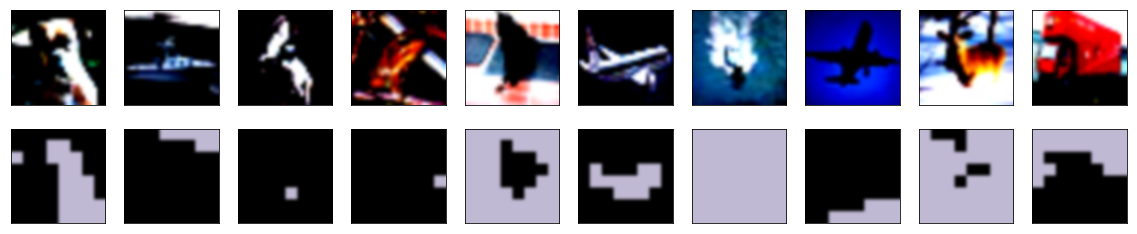

In [27]:
# randomly sample 10 images and look at output
test_sample = sample_array(X_train, k=10)
reconstructions = autoencoder.predict(test_sample)
show_side_by_side(test_sample, reconstructions)

# Semantic hashing

Lastly, we'll take a look at search results given the same query image, but using the "semantic hash table." (implemented in [semantic_hashing.py](https://github.com/dantegates/image-search/blob/master/semantic_hashing.py))

In [ ]:
from semantic_hashing import DB

def make_encoder(autoencoder):
    encoding = autoencoder.get_layer(ENCODING_LAYER_NAME).get_output_at(-1)
    # multiply each bit by its corresponding power of 2 to get d-bit int
    def to_int(X):
        X = K.cast(X, 'int32')  # this only works for latent dims <= 32
        latent_dim = K.int_shape(X)[-1]
        Z = 2**K.arange(latent_dim)
        return K.dot(X, K.reshape(Z, (-1, 1)))
encoding = keras.layers.Lambda

In [ ]:
from semantic_hashing import DB

def make_encoder(autoencoder):
    encoding = autoencoder.get_layer(ENCODING_LAYER_NAME).get_output_at(-1)
    # multiply each bit by its corresponding power of 2 to get d-bit int
    def to_int(X):
        X = K.cast(X, 'int32')  # this only works for latent dims <= 32
        latent_dim = K.int_shape(X)[-1]
        Z = 2**K.arange(latent_dim)
        return K.dot(X, K.reshape(Z, (-1, 1)))
    # not technically the right shape but it doesn't matter
#    encoding = keras.layers.Lambda(to_int, output_shape=lambda x: x)(encoding)
    encoder = keras.models.Model(inputs=autoencoder.input, outputs=encoding)
    return encoder

encoder = make_encoder(autoencoder)

In [ ]:
encoder.summary()

In [ ]:
%%time
db = DB(encoder, X_train)

In [ ]:
# look at some values that make use feel good about our choice of $d$
db.describe()

In [ ]:
%%time
q = sample_array(X_train, 1)
res = db.search(q, threshold=1)
show_side_by_side(q, res)

In [ ]:
q = sample_array(X_train, 1)
encoder.predict(q)

Note that even on this relatively small data set we already observe much faster lookups without any noticable impact to the search performance.

## Resources

For further information see the papers which introduced autoencoders and guided this post are

- [Semantic Hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf)
- [Using Very Deep Autoencoders for Content-Based Image Retrieval](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf).